In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main/")
import networkx as nx
import scanpy as sc
import switch2 as sw
from itertools import chain

In [2]:
os.chdir("../../../DATA/Brain_subregion/")

Preprocess

In [3]:
# rna = sc.read_h5ad("rna.h5ad")
# atac = sc.read_h5ad("atac.h5ad")
# (rna.obs_names==atac.obs_names).all()

In [4]:
# sw.pp.get_gene_annotation(rna, 
#                     gtf="../Mouse_embryo/gencode.vM25.annotation.gtf.gz",
#                     gtf_by="gene_name",
#                     drop_na=True
# )

In [5]:
# rna.layers["counts"] = rna.X.copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3", layer="counts")

In [6]:
# split = atac.var_names.str.split(r"[:-]")
# atac.var["chrom"] = split.map(lambda x: x[0])
# atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
# atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# ## print(i.var)

In [7]:
# print(atac.shape[1])
# sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.01)
# print(atac.shape[1])

In [8]:
# guidance = preprocess.rna_anchored_guidance_graph(rna, atac)
# len(atac.var[atac.var["highly_variable"]==True])

In [9]:
# rna.write("rna-pp.h5ad")
# atac.write("atac-pp.h5ad")
# nx.write_graphml(guidance, "guidance.graphml.gz")
# guidance_hvf = guidance.subgraph(chain(
#    rna.var.query("highly_variable").index,
#    atac.var.query("highly_variable").index
# )).copy()
# nx.write_graphml(guidance_hvf, "guidance_hvf.graphml.gz")

In [10]:
# load the processed data

atac = sc.read_h5ad("atac-pp.h5ad")
rna = sc.read_h5ad("rna-pp.h5ad")
guidance_hvf = nx.read_graphml("guidance_hvf.graphml.gz")

Training

In [11]:
# sc.pp.filter_genes(atac, min_cells=10)
len(atac.var[atac.var["highly_variable"]==True])

12802

In [12]:
sw.pp.setup_data(
    rna, "NB",
    use_highly_variable=True,
    use_layer="counts",
)
sw.pp.setup_data(
    atac, "NB",
    use_highly_variable=True, 
)

In [13]:
sw.pp.cal_spatial_net(rna, cutoff=1, model="Radius")
sw.pp.cal_spatial_net(atac, cutoff=1, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 9222 edges, 2373 spots.
3.8862 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 9222 edges, 2373 spots.
3.8862 neighbors per spot on average.


In [14]:
model = sw.SWITCH(adatas={"rna": rna, "atac": atac}, vertices=sorted(guidance_hvf.nodes), 
               dropout=0.25,
               device="cuda:0")

- INFO - Set random seed to 0


In [15]:
model.compile(lam_graph=0.4, lam_align=.75)

In [16]:
model.pretrain(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=3000, dsc_k=1)

- INFO - Prepare data for training.
- INFO - Pretraining with full batch.
Epoch 3000/3000: 100%|██████████| 3000/3000 [02:34<00:00, 19.40it/s, dsc_loss=0.693, gen_loss=0.380]
- INFO - Model pretrain done.


In [17]:
model.train(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=500, dsc_k=2)

- INFO - Training with full batch.
Epoch 500/500: 100%|██████████| 500/500 [01:21<00:00,  6.17it/s, dsc_loss=0.691, gen_loss=1.318, cycle_loss=0.379, align_loss=0.746]
- INFO - Model training done.


In [18]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [19]:
combined = sc.concat([rna, atac], label="omics")

In [20]:
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30, metric="cosine")
sc.tl.umap(combined)

In [33]:
sc.tl.leiden(adata=combined, resolution=.25, key_added="leiden")
print(len(set(combined.obs["leiden"])))

6


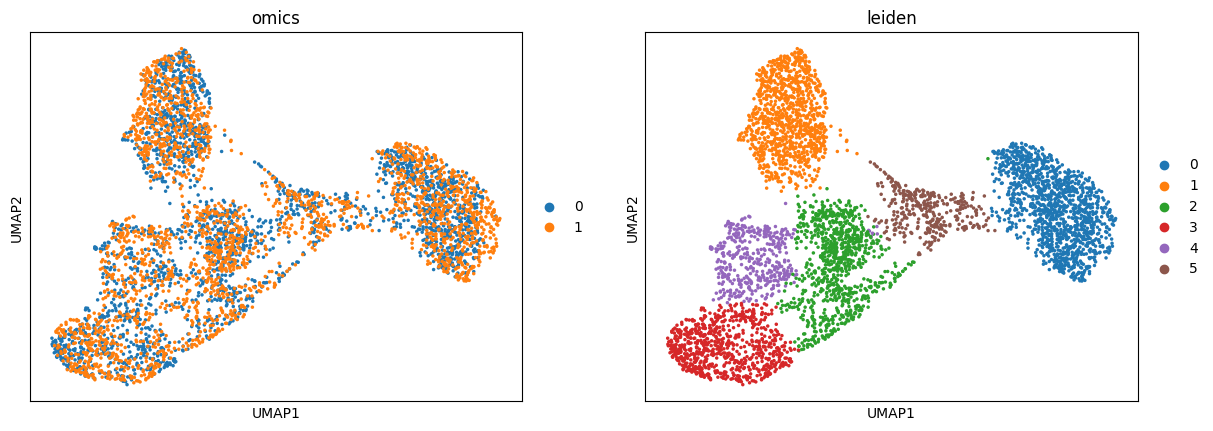

In [34]:
sc.pl.umap(combined, color=["omics","leiden"])

In [35]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

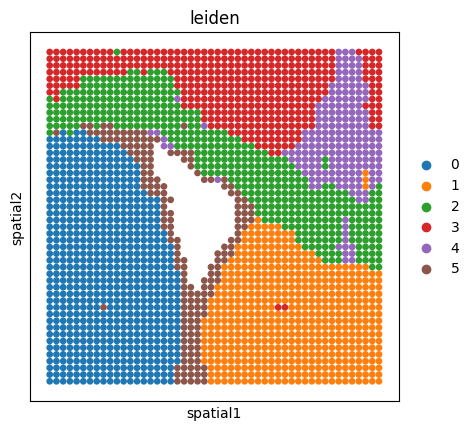

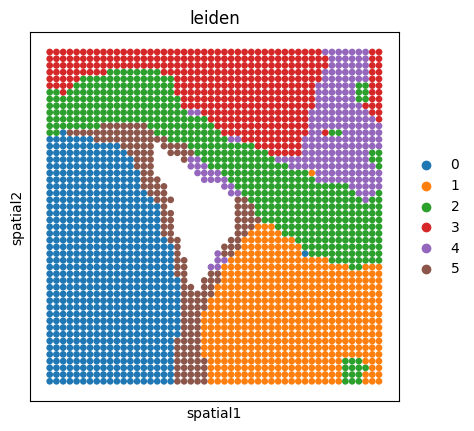

In [36]:
sc.pl.spatial(t_rna, color="leiden",spot_size=1)
sc.pl.spatial(t_atac, color="leiden",spot_size=1)

In [37]:
sw.metrics.foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])

0.05554410136937016

In [38]:
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep4/SWITCH_embed.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep4/SWITCH_umap.csv")
# cluster = pd.DataFrame(combined.obs["leiden"])
# cluster.to_csv("rep4/SWITCH_cluster.csv")